In [1]:
#readFeats
import numpy as np
import pandas as pd
import sklearn
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import os
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import hyperopt
from hyperopt import  hp, fmin, tpe, STATUS_OK, Trials
import time
#import 
import warnings
warnings.simplefilter('ignore')


/home/naireen/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
inj = pd.read_csv("../Data/Injected_feat_files_10000_fixed.csv", index_col=0)
inv = pd.read_csv("../Data/Inverted_feat_files_fixed_detrended.csv", index_col=0)#[:9000]
inj_periods = np.loadtxt("../Catalogs/injection.txt", dtype= str, delimiter=",")[:10000, 3].astype("float64")
inj_SNR = np.loadtxt("../Data/SNR_10000_corrected.txt")[:10000]
inj_tol = np.loadtxt("../Data/period_harmonics_10000_inj_signals_tol_5x5.txt")


koi = pd.read_csv("../Data/KOI_feat_files_3080_relabelled.csv", index_col =0 )
del koi["segment"]
del koi["star_id"]
#koi_tol = np.loadtxt("../Data/period_harmonics_3080_koi_signals_tol_5x5_ordered_try4.txt")
#koi_SNR = np.loadtxt("../Data/SNR_feats_KOIS_3080_fixed_try4.txt")
#KOI_SNR has three columns, the first is starid, the second is segment, and the third column is the SNR value for each segemnt
#koi_periods = np.loadtxt("../Data/koi_periods_try4.txt")

koi_tol = np.loadtxt("../Data/period_harmonics_3080_koi_signals_tol_5x5_ordered_multiplanet.txt")
koi_SNR = np.loadtxt("../Data/SNR_feats_KOIS_3080_fixed_multiplanet.txt")
koi_periods = np.loadtxt("../Data/koi_periods_multiplanet.txt")

#non pimary koi
non_koi = pd.read_csv("../Data/KOI_non_prim_feat_files_20000_new_detrending.csv", index_col=0)[4000:5000]
test_non_kois = pd.read_csv("../Data/KOI_non_prim_feat_files_20000_new_detrending.csv", index_col=0)[5000:15000]

In [12]:
#make cuts to injected and koi samples to determine what should be labelled true
ped_constraint = 3 # transit cut, this ensures there will be atleast three transits in each 26 days segment
SNR_cut =6 # SNR threshold
inj_enough_transits = ((26/inj_periods) > ped_constraint).astype(int)
tolerance_cut = 0.002

#This is to ensure that aleast of the integers used to minimize period error function is 1 (means it 
#detected the correct signal), or that the ratio of the two can be reduced to 1 to 1 
#(in case the model determined the solution to be something like 2:2, which is equivalent to 1:1)
inj_low_tol = ((inj_tol[:,0]==1)+(inj_tol[: ,1]==1) + (inj_tol[:,0] == inj_tol[:,1])).astype(int)

#print "Tolerance Cut", len(np.where(inj_low_tol==1)[0])
print "SNR Cut", len(np.where(inj_SNR>SNR_cut)[0])
inj_true_trans = ((inj_SNR>=SNR_cut)*(inj_tol[:,2]<tolerance_cut)*(inj_low_tol==1)*(inj_enough_transits)).astype(int)
print "Retained Transits", len(np.where(inj_true_trans==1)[0])


#koi_cuts
koi_enough_trans = (26/koi_periods >= ped_constraint).astype(int)
koi_low_tol = ((koi_tol[:,0]==1)+(koi_tol[: ,1]==1) + (koi_tol[:,0] == koi_tol[:,1])).astype(int)
koi_enough_sig = (koi_SNR[:,-1] < SNR_cut).astype(int)
#this is done because this koi happens to have two planets with roughly eqivalent signals
#thus the bls detects both periods, and this ensures that it is not discarded in the error cuts
indices = np.where(koi_SNR[:,0] == 2989404)[0]
print indices
koi_low_tol[indices] = 1  

#mkoi_enough_trans = (26/mkoi_periods >= ped_constraint).astype(int)
#print mkoi_tol.shape, mkoi_SNR.shape
#mkoi_low_tol =((mkoi_tol[:,0]==1)+(mkoi_tol[: ,1]==1) + (mkoi_tol[:,0] == mkoi_tol[:,1])).astype(int)
#mkoi_enogh_sig = (mkoi_SNR[:, -1] >SNR_cut).astype(int)

koi_true_trans = (koi_enough_trans* koi_low_tol * koi_enough_sig).astype(int)
print "Retained Transits", len(np.where(koi_true_trans==1)[0]), "from", koi.shape[0]

#koi_true_trans = (mkoi_enough_trans* mkoi_enogh_sig * mkoi_low_tol ).astype(int)
#print "Retained Transits", len(np.where(koi_true_trans==1)[0]), "from", koi.shape[0]

SNR Cut 9255
Retained Transits 6215
[913 914 915 916 917 918 919 920 921 922 923 924]
Retained Transits 795 from 3080


In [13]:
#append Y values
inj["Y"] = inj_true_trans
inv["Y"] = np.zeros(inv.shape[0])
non_koi["Y"] = np.zeros(non_koi.shape[0])

object_labels = np.hstack([np.ones(inj.shape[0]),np.zeros(inv.shape[0])+2,  np.zeros(non_koi.shape[0])+4])
total_signals = pd.concat([inj, inv,  non_koi], axis = 0)

# 1 inj , 2 inv, 3 koi, 4 non kois
#these are object labels given to track the objects later through shuffling and train test splitting
drop_column =  ["BLS_Npointsaftertransit_1_0", "BLS_Npointsintransit_1_0", "BLS_Npointsbeforetransit_1_0",
                "BLS_OOTmag_1_0", "BLS_Tc_1_0", "BLS_Period_1_0"]
total_signals = total_signals.drop(drop_column, axis = 1)
test_non_kois = test_non_kois.drop(drop_column, axis=1)
koi = koi.drop(drop_column, axis = 1)
labels = total_signals["Y"]
del total_signals["Y"]
total_signals.head(1)

,mod_sig_pri_dv,mod_sig_sec_dv,mod_sig_ter_dv,mod_sig_pos_dv,mod_fa1_dv,mod_fa2_dv,mod_fred_dv,modshiftval1_dv,modshiftval2_dv,modshiftval3_dv,...,BLS_Qtran_1_0,BLS_Qingress_1_0,BLS_i1_1_0,BLS_i2_1_0,BLS_deltaChi2_1_0,BLS_fraconenight_1_0,BLS_Ntransits_1_0,BLS_Rednoise_1_0,BLS_Whitenoise_1_0,BLS_SignaltoPinknoise_1_0
0,0.00028,-9.999884,0.000098,-0.000186,2.991073,2.538906,1.040623,-2.990804,-2.538725,-2.53844,...,0.08623,0.18903,0.35772,0.44395,-0.00001,0.31843,4.0,0.00004,0.00031,7.72038


In [14]:
shuffleX, shuffleY , shuffle_labels= shuffle(total_signals, labels, object_labels, random_state =0)
shuffleX = shuffleX.reset_index(drop = True)
shuffleY = shuffleY.reset_index(drop = True)

print shuffleX.shape, shuffleY.shape 
trainX, testX, trainY, testY, train_label, test_label = train_test_split(shuffleX, shuffleY, shuffle_labels, stratify =shuffle_labels, test_size = 0.20,random_state = 0 )

print "Strong Transits in training" , len(np.where([(trainY==1) & (train_label==1)])[0]) 
print "Weak Transits in training" , len(np.where([(trainY==0) & (train_label==1)])[0]) 
print "Inverted Signals in training" , len(np.where([(trainY==0) & (train_label==2)])[0]) 
print "Non kois in Training", len(np.where([(trainY==0) & (train_label==4)])[0]) ,"\n"
print "Strong Transits in testing" , len(np.where([(testY==1) & (test_label==1)])[0]) 
print "Weak Signals in testing" , len(np.where([(testY==0) & (test_label==1)])[0]) 
print "Inverted Signals in testing" , len(np.where([(testY==0) & (test_label==2)])[0]) 
print "Non kois in Testing", len(np.where([(testY==0) & (test_label==4)])[0]) 

(26000, 29) (26000,)
Strong Transits in training 4979
Weak Transits in training 3021
Inverted Signals in training 12000
Non kois in Training 800 

Strong Transits in testing 1236
Weak Signals in testing 764
Inverted Signals in testing 3000
Non kois in Testing 200


In [15]:
#define model and parameters
xgbc = XGBClassifier(seed = 0, max_depth=20, min_child_weight=5, subsample=0.95, colsample_bytree=0.9, n_estimators=500, scale_pos_weight=30, learning_rate=0.02 )
xgbc.fit(trainX, trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=20,
       min_child_weight=5, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=30, seed=0, silent=True, subsample=0.95)

In [16]:
preds = xgbc.predict(testX)
print "Area under precision recall curve", metrics.average_precision_score(testY, preds)
print "Strong Injections detected", len(np.where((preds==1)&(test_label==1)&(testY==1))[0]),"from", len(np.where((test_label==1)&(testY==1))[0])
print "Weak Injections detected with period cut", len(np.where((preds==1)&(test_label==1)&(testY==0))[0]),"from", len(np.where((test_label==1)&(testY==0))[0])

print "Inverted Rejected", len(np.where((preds==0)&(test_label==2)&(testY==0))[0]),"from", len(np.where((test_label==2)&(testY==0))[0])
print "NON_KOI_Rejected", len(np.where((preds==0)&(test_label==4)&(testY==0))[0]),"from", len(np.where((test_label==4)&(testY==0))[0])
preds_non_kois = xgbc.predict(test_non_kois)
print "NON_kois_test_set rejected", len(np.where(preds_non_kois==0)[0]), "from 10000" 

Area under precision recall curve 0.983999055061
Strong Injections detected 1218 from 1236
Weak Injections detected with period cut 24 from 764
Inverted Rejected 3000 from 3000
NON_KOI_Rejected 198 from 200
NON_kois_test_set rejected 9868 from 10000


(283,)
Unique starts 283
1.0 6
3.0 6
4.0 12
1.0 11
3.0 11
4.0 10
4.0 13
1.0 10
2.0 9
0.0 4
1.0 7
2.0 14
3.0 9
5.0 12
2.0 6
2.0 9
2.0 12
0.0 5
1.0 2
1.0 5
6.0 12
2.0 13
0.0 12
2.0 9
2.0 7
5.0 13
3.0 13
3.0 13
2.0 12
2.0 9
4.0 15
2.0 9
1.0 6
1.0 4
3.0 17
1.0 13
2.0 10
3.0 15
7.0 20
9.0 16
2.0 10
4.0 15
3.0 10
1.0 11
2.0 12
4.0 12
2.0 7
1.0 8
1.0 12
3.0 14
0.0 10
5.0 16
3.0 11
2.0 8
1.0 10
4.0 9
1.0 6
3.0 7
2.0 11
1.0 10
3.0 12
3.0 11
3.0 13
1.0 9
3.0 14
4.0 14
3.0 14
3.0 7
1.0 16
4.0 14
0.0 12
4.0 17
1.0 11
3.0 8
6.0 12
3.0 11
2.0 15
4.0 13
1.0 5
3.0 11
1.0 8
2.0 11
3.0 15
2.0 8
2.0 13
4.0 13
4.0 10
1.0 11
2.0 13
3.0 15
1.0 13
4.0 13
0.0 7
1.0 5
1.0 8
4.0 6
2.0 11
4.0 9
4.0 15
0.0 6
2.0 13
2.0 13
3.0 7
2.0 9
2.0 11
4.0 15
3.0 9
4.0 10
1.0 15
5.0 15
2.0 6
1.0 6
4.0 16
1.0 14
2.0 4
3.0 7
4.0 14
3.0 16
2.0 15
1.0 7
0.0 15
3.0 8
0.0 14
2.0 6
1.0 7
2.0 7
0.0 7
3.0 9
4.0 15
3.0 8
2.0 16
3.0 11
2.0 11
3.0 17
1.0 9
1.0 8
3.0 9
1.0 8
1.0 8
3.0 12
2.0 11
1.0 6
1.0 14
2.0 12
3.0 11
4.0 9
1.0 7
2.0 

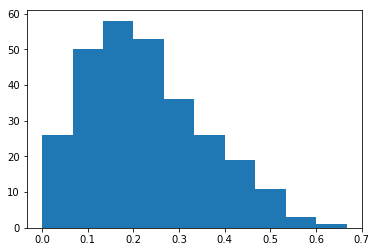

In [17]:
#This groups the predictions of the kois per star.

preds =xgbc.predict(koi) 
star_list_ids = np.unique(koi_SNR[:,0]) 
partially_detected = np.zeros_like(star_list_ids) #flag to see if at least one segment for that stasr was detected
detection_counts = np.zeros_like(star_list_ids)# raw count of segments per star that were detected
normalized_detection_counts = np.zeros_like(star_list_ids) # percentage of segments detected for each star id
not_detected = np.zeros_like(star_list_ids) # flag for stars not detected 1== not detected in any of its segments

print star_list_ids.shape
star_SNR =np.zeros_like(star_list_ids)
star_tol = np.zeros_like(star_list_ids)
star_transits = np.zeros_like(star_list_ids)
star_period = np.zeros_like(star_list_ids)

print "Unique starts" ,len(star_list_ids)

for i,id_num in enumerate(star_list_ids):
    indices = np.where(id_num == koi_SNR[:,0])[0]
    #print indices
    if  preds[indices].sum() >=1:
        partially_detected[i] = star_list_ids[i]
    else  :
        not_detected[i] = star_list_ids[i]
    detection_counts[i]=preds[indices].sum()
    normalized_detection_counts[i] = np.nansum(preds[indices].sum()/ len(np.where(preds[indices]!=np.nan)[0]))
    print np.nansum(preds[indices].sum()), len(np.where(preds[indices]!=np.nan)[0]) 
    star_SNR[i] = np.median(koi_SNR[indices,2])
    star_transits[i] = np.median(26//koi_periods[indices])
    star_tol[i] = np.median(koi_tol[indices,2])
    star_period[i] = np.median(koi_periods[indices])
    #The SNR of this star is incorrect, as it was uncorrectly detrended due to its short timescale variation(less than a day)
    #Thus the SNR for this star is manually set to zero
    if id_num==10736489:
        star_SNR[i]= 0

print "Stars detected", len(np.where(partially_detected!=0)[0])
plt.hist(normalized_detection_counts)
print "Stars Missed" , len(not_detected[np.where(not_detected!=0)[0]])